# DINOv2 for Sparce Feature Matching

* DINOv2 paper: https://arxiv.org/abs/2304.07193


* DINOv2 docs: https://huggingface.co/docs/transformers/main/model_doc/dinov2.

* DINOv2 Meta demos: https://dinov2.metademolab.com/.

* DINOv2 Meta repository: https://github.com/facebookresearch/dinov2

* Useful Meta tutorials on Segmentation and Depth Estimation: https://github.com/facebookresearch/dinov2/tree/main/notebooks

* SPAIR_71k dataset: https://cvlab.postech.ac.kr/research/SPair-71k/

* SIFT implementation and Taj Mahal examples: https://github.com/OpenGenus/SIFT-Scale-Invariant-Feature-Transform

Useful imports

In [166]:
import os
import math
import tarfile

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec


Add SPair-71k dataset to your drive account, correct the path and let this block extract the dataset if not already present in the virtual folder

In [167]:
# === CONFIG ===
tar_filename = "SPair-71k.tar.gz"
tar_path = f"/content/{tar_filename}"
extract_dir = "/content/SPair-71k"
aeroplane_dir = os.path.join(extract_dir, "SPair-71k", "JPEGImages", "aeroplane")

# === Download from Google Drive if not already present (faster) ===
if not os.path.exists(tar_path):
    print("📁 Tar not found in /content folder. Mounting on Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive')

    gdrive_tar_path = "/content/drive/MyDrive/CV_stuff/SPair-71k.tar.gz"

    if not os.path.exists(gdrive_tar_path):
        raise FileNotFoundError(f"❌ File non trovato: {gdrive_tar_path}")

    print("⬇️ Copying file from Google Drive...")
    os.system(f"cp '{gdrive_tar_path}' '{tar_path}'")
else:
    print("✅ Tar already present in /content folder, no download needed.")

# === Extracting if not already present ===
if not os.path.exists(extract_dir) or not os.path.exists(aeroplane_dir):
    print("📦 Extracting tar.gz...")
    os.makedirs(extract_dir, exist_ok=True)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)
else:
    print("✅ Files are already extracted.")

# === Check pathfile ===
if os.path.exists(aeroplane_dir):
    print(f"🔍 Test folder found: {aeroplane_dir}")
else:
    raise FileNotFoundError(f"❌ Folder {aeroplane_dir} not found.")


✅ Tar already present in /content folder, no download needed.
✅ Files are already extracted.
🔍 Test folder found: /content/SPair-71k/SPair-71k/JPEGImages/aeroplane


DINOv2 model configuration

In [168]:
# === CONFIG ===

# Hard dataset with images linked only by the class of objects present
# dataset_path = "/content/SPair-71k/SPair-71k/JPEGImages/bird"

# 2 images from two different perspectives of the Taj Mahal (for the SIFT comparison)
dataset_path = "/content/TajMahal"

# Load DINOv2 backbone
backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
    "small_reg": "vits14_reg",
    "base_reg": "vitb14_reg",
    "large_reg": "vitl14_reg",
    "giant_reg": "vitg14_reg",
}

BACKBONE_SIZE = "base_reg"
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Image and DINOv2 patch sizes
img_size = 448 # in 448 or 896
patch_size = 14

# Load DINOv2 model
backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()

# Check for CUDA (GPU) availability and move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone_model.to(device)  # Move model to CPU or GPU

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

Image preprocessing

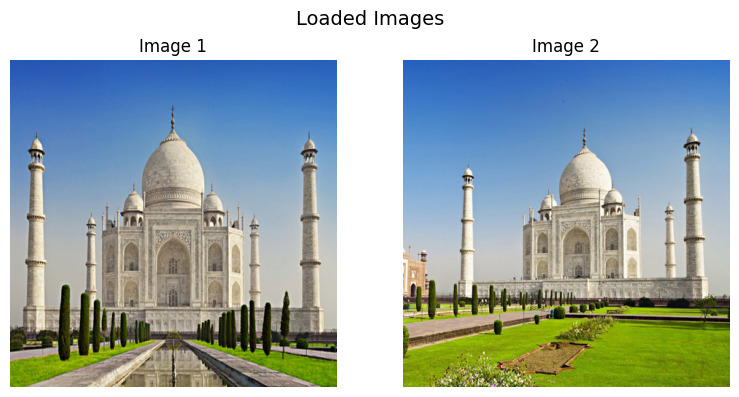

In [169]:
# Resize two PIL images to the same size and display them side by side.
def show_resized_loaded_images(img1, img2, title="Resized Images"):
    img1_resized = img1.resize((img_size, img_size))
    img2_resized = img2.resize((img_size, img_size))

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(title, fontsize=14)

    axes[0].imshow(img1_resized)
    axes[0].set_title("Image 1")
    axes[0].axis("off")

    axes[1].imshow(img2_resized)
    axes[1].set_title("Image 2")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# === Image Preprocessing ===

# Load all images in the datapath
image_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.jpg')])

# Choose images by their index in image_files

# img1_path = os.path.join(dataset_path, image_files[30])
# img2_path = os.path.join(dataset_path, image_files[31])

img1_path = os.path.join(dataset_path, image_files[0])
img2_path = os.path.join(dataset_path, image_files[1])

# Load the input images and ensure they are in RGB mode (remove alpha channel if present)
img1 = Image.open(img1_path).convert("RGB")
img2 = Image.open(img2_path).convert("RGB")

# Show the loaded images
show_resized_loaded_images(img1, img2, title="Loaded Images")

# Define preprocessing pipeline:
# - ensure RGB mode,
# - resize to fixed size (img_size x img_size),
# - convert to tensor,
# - normalize using ImageNet mean and std (the ones used for the training of the model)
transform = transforms.Compose([
    lambda img: img.convert("RGB"),  # Remove alpha channel if present
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply preprocessing and add batch dimension: shape becomes [batch_size = 1, channels, height, width]
img1_tensor = transform(img1).unsqueeze(0)
img2_tensor = transform(img2).unsqueeze(0)



Show the extracted images

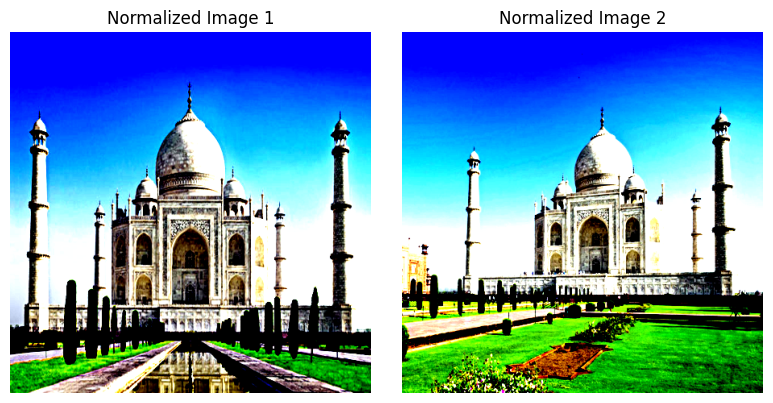

In [170]:
def prepare_tensor_image(img_tensor):
    # Remove batch dimension and clamp to [0, 1]
    img = img_tensor.squeeze().clamp(0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

def show_tensor_images_side_by_side(img1_tensor, img2_tensor, titles=("Image 1", "Image 2")):
    img1_np = prepare_tensor_image(img1_tensor)
    img2_np = prepare_tensor_image(img2_tensor)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

    for ax, img_np, title in zip(axes, [img1_np, img2_np], titles):
        ax.imshow(img_np)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Usage
show_tensor_images_side_by_side(img1_tensor, img2_tensor, titles=("Normalized Image 1", "Normalized Image 2"))


Extract embeddings from the model

In [171]:
# Inference mode: disable gradient computation
# Extract features from the model for both images (e.g., DINOv2 backbone)
with torch.no_grad():
    features1 = backbone_model.forward_features(img1_tensor.to(device))
    features2 = backbone_model.forward_features(img2_tensor.to(device))

# Discard batch dimension and keep normalized patch token embeddings
# Output shape: [num_patches, embedding_dim]
emb1 = features1["x_norm_patchtokens"][0]
emb2 = features2["x_norm_patchtokens"][0]


Visualize feature norms

<ipython-input-172-4c0bbaaa66af>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


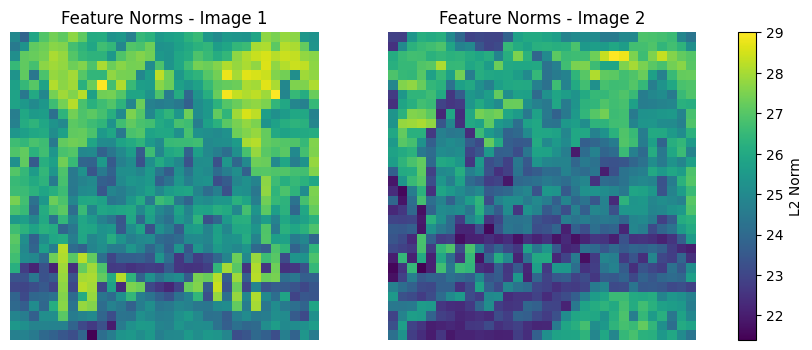

In [172]:
def compute_norm_map(embeddings):
    # Compute L2 norm (Euclidean norm) of each patch embedding
    norms = torch.norm(embeddings, dim=1).cpu().numpy()
    # If img_size = 446 and patch_size = 14  ->  446 / 14 = 32  ->  32 x 32 = 1024 patches grid
    grid_size = int(np.sqrt(len(norms)))
    # Reshape into 2D grid
    return norms.reshape((grid_size, grid_size))

def visualize_feature_norms_2_images(emb1, emb2, img_size, titles=("Image 1", "Image 2")):
    norm_map1 = compute_norm_map(emb1)
    norm_map2 = compute_norm_map(emb2)

    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    cax = fig.add_subplot(gs[2])  # colorbar axis

    im1 = ax1.imshow(norm_map1, cmap="viridis")
    ax1.set_title(titles[0])
    ax1.axis("off")

    im2 = ax2.imshow(norm_map2, cmap="viridis")
    ax2.set_title(titles[1])
    ax2.axis("off")

    # Use the last image for colorbar scaling (same colormap anyway)
    cbar = fig.colorbar(im2, cax=cax)
    cbar.set_label("L2 Norm")

    plt.tight_layout()
    plt.show()

# Usage
visualize_feature_norms_2_images(emb1, emb2, img_size, titles=("Feature Norms - Image 1", "Feature Norms - Image 2"))

Filtering Foreground from the Background according to the procedure described in the [paper on DINOv2](https://arxiv.org/abs/2304.07193)
:

1. **Foreground Detection via PCA (per individual image)**  
   - For each image, patch embeddings are reduced to a single principal component (PC1).  
   - Foreground regions are detected by thresholding: **only patches where PC1 > 0** are considered foreground. This provides a simple and effective separation between salient object regions and background.

2. **Joint PCA on Foreground Patches**  
   - The foreground embeddings from both images are concatenated into a single dataset.  
   - A **joint PCA** is performed on this combined foreground set to uncover shared semantic structure across both images.

3. **Projection of All Patches**  
   - The learned PCA components are then used to project **all patches** (not just the foreground) from both images into the same PCA space.  
   - This ensures that patch comparisons across images are done in a common semantic space.

NOTES: filtering on the positive values of the first principal component doesn't always separate the foreground from the background, sometimes it does the opposite (depending on the images and the chosend backbone)

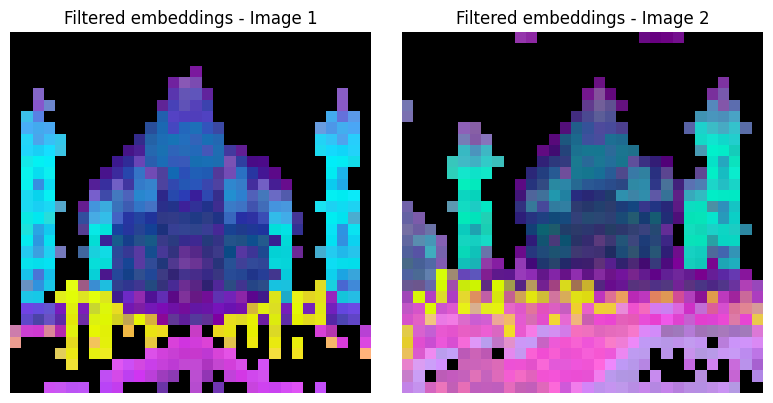

In [173]:
def filter_and_visualize_extracted_features(emb1, emb2, title1="Image 1", title2="Image 2", img_size=448, patch_size=14):
    """
    Applies PCA transformations individually to extract features and then another time on all images to visualize the top 3 PCA components as RGB channels.

    Returns:
        emb1_np: numpy array of embeddings from image 1
        emb2_np: numpy array of embeddings from image 2
        fg_mask1: boolean mask of foreground patches in image 1
        fg_mask2: boolean mask of foreground patches in image 2
        grid_size: number of patches per row/column
        rgb1: RGB PCA visualization of image 1
        rgb2: RGB PCA visualization of image 2
    """
    # Correct the sign ambiguity typical of the PCA on the first principal component based on foreground/background balance
    # NOTE: not in the paper, but sometimes improves performance
    def correct_pc1_sign(pc1):
        sorted_pc1 = np.sort(pc1)
        top_k_mean = sorted_pc1[-len(pc1)//4:].mean()     # Mean of top 25% values
        bottom_k_mean = sorted_pc1[:len(pc1)//4].mean()   # Mean of bottom 25% values
        return pc1 if top_k_mean > abs(bottom_k_mean) else -pc1

    # Create a binary mask by applying PCA to each embedding set individually
    def get_foreground_mask_by_pc1(emb_np):
        # Normalize embeddings
        scaler = StandardScaler()
        emb_scaled = scaler.fit_transform(emb_np)

        # Extract only the first principal component
        local_pca = PCA(n_components=1)
        pc1 = local_pca.fit_transform(emb_scaled)[:, 0]

        # Dynamically correct sign if needed
        # pc1 = correct_pc1_sign(pc1)

        # Foreground mask: retain only patches where PC1 > 0
        mask = pc1 > 0
        return mask

    # Normalize each PCA channel and map it into RGB for visualization
    def normalize_and_colorize(reduced, mask, grid_size):
      # Total number of patch embeddings (reduced is an array of PCA reduced embeddings with shape [num_patches, 3])
      total_patches = reduced.shape[0]

      # Initialize an empty RGB image (black by default)
      rgb_image = np.zeros((total_patches, 3), dtype=np.uint8)

      # For each of the first 3 PCA components, treat it as one color channel
      for i in range(3):
          channel = reduced[:, i]      # Get values for the i-th PCA component
          fg = channel[mask]           # Select values corresponding to foreground patches only

          # Normalize the foreground values to [0, 1] and scale to [0, 255]
          if fg.size > 0:
              fg = fg - fg.min()                       # Shift so min is 0
              fg = fg / (fg.max() + 1e-8)              # Scale to [0, 1], avoid division by zero
              rgb_image[mask, i] = (fg * 255).astype(np.uint8)  # Convert to 8-bit color values

      # Reshape the flat RGB array into a 2D image with 3 color channels
      return rgb_image.reshape(grid_size, grid_size, 3)

    # Convert PyTorch tensors to NumPy arrays
    emb1_np = emb1.cpu().numpy()
    emb2_np = emb2.cpu().numpy()

    # Compute foreground masks using local PCA on each embedding set
    fg_mask1 = get_foreground_mask_by_pc1(emb1_np)
    fg_mask2 = get_foreground_mask_by_pc1(emb2_np)

    # Apply mask on the individual embeddings (remove background)
    emb1_fg = emb1_np[fg_mask1]
    emb2_fg = emb2_np[fg_mask2]
    combined_fg = np.concatenate([emb1_fg, emb2_fg], axis=0)

    # Fit scaler on all embeddings (foreground + background)
    all_embeddings = np.concatenate([emb1_np, emb2_np], axis=0)
    scaler = StandardScaler()
    scaler.fit(all_embeddings)

    # Scale foreground embeddings for PCA training
    combined_fg_scaled = scaler.transform(combined_fg)

    ## Joint PCA on foreground patches from both images
    pca = PCA(n_components=3)
    pca.fit(combined_fg_scaled)

    # Apply the same PCA to all patches (not just foreground)
    emb1_scaled_all = scaler.transform(emb1_np)
    emb2_scaled_all = scaler.transform(emb2_np)
    reduced1 = pca.transform(emb1_scaled_all)
    reduced2 = pca.transform(emb2_scaled_all)

    # Create colorized RGB maps using PCA-reduced channels
    grid_size = img_size // patch_size
    rgb1 = normalize_and_colorize(reduced1, fg_mask1, grid_size)
    rgb2 = normalize_and_colorize(reduced2, fg_mask2, grid_size)

    # Display both RGB maps side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(rgb1)
    axs[0].set_title(f"{title1}")
    axs[0].axis("off")

    axs[1].imshow(rgb2)
    axs[1].set_title(f"{title2}")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Return data for further use (e.g. for matching, masks, etc.)
    return emb1_np, emb2_np, fg_mask1, fg_mask2, grid_size, rgb1, rgb2

# Show embeddings as RGB maps for foreground only
emb1_np, emb2_np, fg_mask1, fg_mask2, grid_size, rgb1, rgb2 = filter_and_visualize_extracted_features(emb1, emb2, title1="Filtered embeddings - Image 1", title2="Filtered embeddings - Image 2", img_size=img_size, patch_size=patch_size)

Extract the feature matches from the 2 image embeddings

In [174]:
def match_foreground_patches(emb1_np, emb2_np, fg_mask1, fg_mask2, grid_size, top_k=50):
    # Extract only the patch features that belong to the foreground (PC1 > 0)
    feats1 = emb1_np[fg_mask1]
    feats2 = emb2_np[fg_mask2]

    # Handle the case where one of the images has no detected foreground patches
    if feats1.shape[0] == 0 or feats2.shape[0] == 0:
        print("No matches: one of the foreground masks is empty.")
        return []

    # Compute the pairwise Euclidean distance matrix between all foreground patch features
    # dist is a matrix where dists[i,j] = ∥feats1[i] − feats2[j]∥
    dists = cdist(feats1, feats2, metric='euclidean')

    # Solve the linear assignment problem (Hungarian Algorithm) to find one-to-one matches between feats minimizing totale distance
    row_ind, col_ind = linear_sum_assignment(dists)

    # Extract the distances of the selected matches
    match_dists = dists[row_ind, col_ind]

    # Sort matches by distance (lower is better)
    sorted_idx = np.argsort(match_dists)

    # Keep only the top_k best matches
    top_idx = sorted_idx[:top_k]

    # Convert local foreground indices back to global grid indices
    fg_idx1 = np.where(fg_mask1)[0][row_ind[top_idx]]
    fg_idx2 = np.where(fg_mask2)[0][col_ind[top_idx]]

    # Return a list of tuples: (index in image1, index in image2, match distance)
    matches = list(zip(fg_idx1, fg_idx2, match_dists[top_idx]))
    return matches

num_matches = 50
matches = match_foreground_patches(emb1_np, emb2_np, fg_mask1, fg_mask2, grid_size, top_k=num_matches)

Visualize the found matches

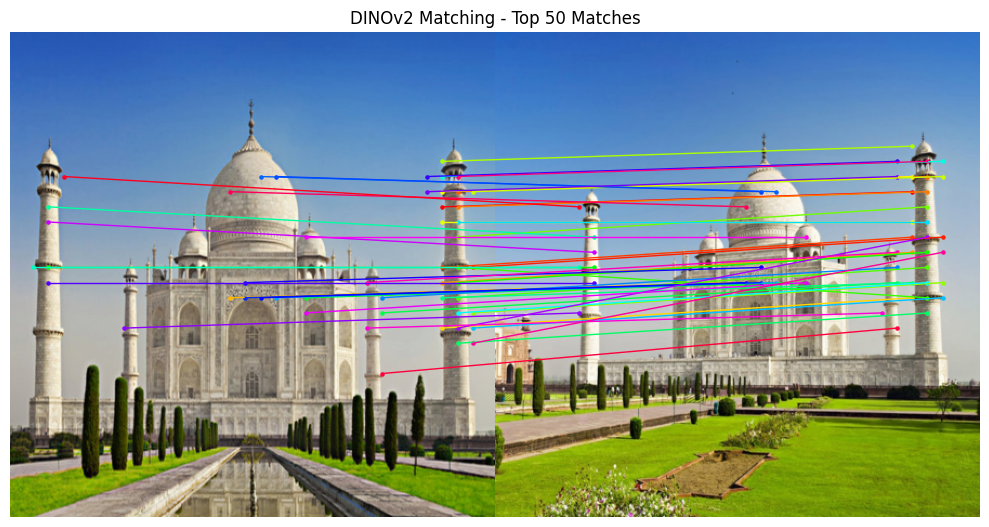

In [175]:
# Converts a PyTorch tensor image to a NumPy array in HWC format
def tensor_to_np(img_tensor):
    if img_tensor.dim() == 4 and img_tensor.shape[0] == 1:
        # Remove batch dimension if present
        img_tensor = img_tensor.squeeze(0)
    img_np = img_tensor.detach().cpu().numpy()
    # Convert from CHW to HWC
    img_np = np.transpose(img_np, (1, 2, 0))
    # Scale to 0-255
    img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    return img_np

def visualize_patch_matches(img1_tensor, img2_tensor, matches, grid_size, patch_size, num_matches, title="Patch Matches"):
    # Convert images to tensors
    img1 = tensor_to_np(img1_tensor)
    img2 = tensor_to_np(img2_tensor)

    # Resize image 2 to match image 1 if needed (ensure same height)
    if img1.shape[0] != img2.shape[0]:
        img2 = np.array(Image.fromarray(img2).resize((img1.shape[1], img1.shape[0])))

    # Prepare a canvas for side-by-side visualization
    h, w, _ = img1.shape
    canvas = np.ones((h, w * 2, 3), dtype=np.uint8) * 255
    canvas[:, :w] = img1
    canvas[:, w:] = img2

    # Convert a patch index into the coordinates of the patch center
    def idx_to_coords(idx):
        row = idx // grid_size
        col = idx % grid_size
        y = row * patch_size + patch_size // 2
        x = col * patch_size + patch_size // 2
        return x, y

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(canvas)

    for i, (idx1, idx2, _) in enumerate(matches):
        # Coordinates in the left image
        x1, y1 = idx_to_coords(idx1)
        # Coordinates in the right image
        x2, y2 = idx_to_coords(idx2)
        # Shift x2 for the right image location
        x2 += w

        # Assign a unique color by cycling through hue values in HSV space (values between 0 and 1)
        hue = (i / len(matches)) % 1.0
        # Convert HSV to RGB (bright and saturated)
        color = mcolors.hsv_to_rgb((hue, 1.0, 1.0))

        # Draw a line between matched patches and highlight both ends
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=1)
        ax.scatter([x1, x2], [y1, y2], color=color, s=5)

    ax.set_title(f"DINOv2 Matching - Top {num_matches} Matches")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Reverses the standard ImageNet normalization on a tensor image.
def undo_normalization(tensor_image):
    # Remove batch dimension if present
    if tensor_image.dim() == 4 and tensor_image.shape[0] == 1:
        tensor_image = tensor_image.squeeze(0)

    # Define inverse normalization using ImageNet statistics
    inv_normalize = transforms.Normalize(
        # negate and divide by std
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        # reciprocal of std
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    # Apply inverse normalization and clamp values to valid image range [0, 1]
    return inv_normalize(tensor_image).clamp(0, 1)

# Undo normalization for visualization or other purposes
img1_tensor = undo_normalization(img1_tensor)
img2_tensor = undo_normalization(img2_tensor)

visualize_patch_matches(img1_tensor, img2_tensor, matches, grid_size, patch_size, num_matches)

Apply SIFT (Scale-Invariant Feature Transform) to compare results

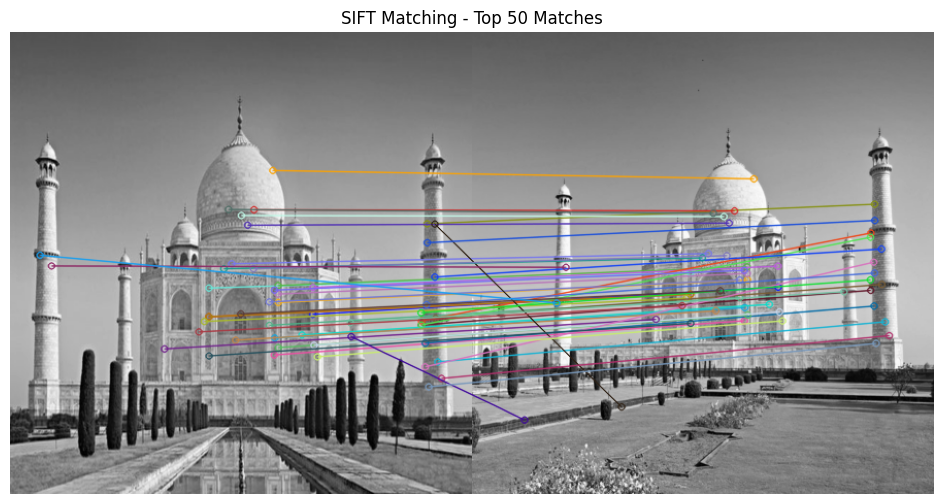

In [176]:
# Convert a PyTorch tensor to a grayscale NumPy image
def tensor_to_gray_np(img_tensor):
    img = img_tensor.squeeze().detach().cpu()
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return gray

def sift_match_and_visualize(img1_tensor, img2_tensor, max_matches=50):
    # Convert both input tensors to grayscale NumPy arrays
    gray1 = tensor_to_gray_np(img1_tensor)
    gray2 = tensor_to_gray_np(img2_tensor)

    # Create a SIFT object
    sift = cv2.SIFT_create()

    # Extract keypoints and descriptors from both grayscale images
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # If no descriptors are found in either image, exit early
    if des1 is None or des2 is None:
        print("No descriptors found in one of the images.")
        return

    # Create a brute-force matcher with L2 norm and cross-check
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors between the two images
    matches = bf.match(des1, des2)

    # Sort matches by distance (lower distance = better match)
    matches = sorted(matches, key=lambda x: x.distance)[:max_matches]

    # Convert grayscale images to RGB so it is possible to draw color matches
    img1_rgb = cv2.cvtColor(gray1, cv2.COLOR_GRAY2RGB)
    img2_rgb = cv2.cvtColor(gray2, cv2.COLOR_GRAY2RGB)

    # Draw the top k matches between the two images
    match_img = cv2.drawMatches(img1_rgb, kp1, img2_rgb, kp2, matches, None, flags=2)

    # Display the result using matplotlib
    plt.figure(figsize=(12, 6))
    plt.imshow(match_img)
    plt.title(f"SIFT Matching - Top {max_matches} Matches")
    plt.axis("off")
    plt.show()

sift_match_and_visualize(img1_tensor, img2_tensor)